In [0]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = tf.keras.datasets.fashion_mnist.load_data()  #FASHION ITEMS

#(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = tf.keras.datasets.mnist.load_data()  #Handwritten digits

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
Y_train_orig = Y_train_orig.reshape(Y_train_orig.shape[0],1)
Y_test_orig = Y_test_orig.reshape(Y_test_orig.shape[0],1)
print("Shape of X_train" + str(X_train_orig.shape))
print("Shape of Y_train" + str(Y_train_orig.shape))
print("Shape of X_test" + str(X_test_orig.shape))
print("Shape of Y_test" + str(Y_test_orig.shape))
m = len(X_train_orig)
m_test = len(X_test_orig)
print("No. of training examples = " +str(m))
print("No. of test examples = " +str(m_test))

Shape of X_train(60000, 28, 28)
Shape of Y_train(60000, 1)
Shape of X_test(10000, 28, 28)
Shape of Y_test(10000, 1)
No. of training examples = 60000
No. of test examples = 10000


Y = [2]


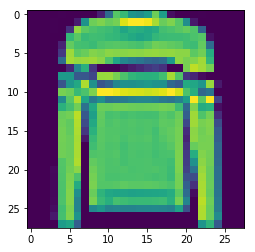

In [0]:
index = 5
plt.imshow(X_train_orig[index])
print("Y = "+str(Y_train_orig[index]))

In [0]:
def one_hot(no_classes,Y):
    targets = np.array(Y).reshape(-1)
    Y = np.eye(no_classes)[targets]
    Y=Y.T
    return Y

In [0]:
X_train = X_train_orig.reshape(60000,28,28,1)
X_test  = X_test_orig.reshape(10000,28,28,1)
X_train = X_train/255
X_test = X_test/255

no_classes = 10

Y_train = one_hot(no_classes,Y_train_orig)
Y_test = one_hot(no_classes,Y_test_orig)
Y_train = Y_train.T
Y_test = Y_test.T


print("Shape of Y :" + str(Y_train.shape))
X_train.shape

Shape of Y :(60000, 10)


(60000, 28, 28, 1)

In [0]:
def create_placeholder(X_train,Y_train,X_test,Y_test):
    
    X_train = tf.placeholder(name = "X_train" , shape = [None,X_train.shape[1],X_train.shape[2],X_train.shape[3]] , dtype =tf.float32 )
    Y_train = tf.placeholder(name = "Y_train" , shape = [None,Y_train.shape[1]] , dtype =tf.float32 )
    X_test = tf.placeholder(name = "X_test" , shape = [None,X_test.shape[1],X_test.shape[2],X_test.shape[3]] , dtype =tf.float32 )
    Y_test = tf.placeholder(name = "Y_test" , shape = [None,Y_test.shape[1]] , dtype =tf.float32 )
    
    return X_train,Y_train,X_test,Y_test

In [0]:
def initialize_parameters():
    
    p={}
    
    p['W1'] = tf.get_variable(name="W1",shape=[3, 3,1,20], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    p['W2'] = tf.get_variable(name="W2",shape=[3, 3, 20,50 ], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    
    return p

In [0]:
def forward_prop(X,parameters):
    
    Z1 = tf.nn.conv2d(X,parameters['W1'],strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    
    P1 = tf.nn.max_pool(A1, ksize = [1,3,3,1], strides = [1,2,2,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,parameters['W2'],strides = [1,2,2,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,2,2,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2,1200,activation_fn=tf.nn.relu) 
    Z3 = tf.layers.dropout(Z3, rate=0.5) 
    
    Z3 = tf.contrib.layers.fully_connected(Z3,10,activation_fn=None)
    
    return Z3

In [0]:
def compute_cost(Y,Z3):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3 , labels = Y))
    
    return cost

In [0]:
parameters = initialize_parameters()

In [0]:
def model(X_train, Y_train,X_test,Y_test,parameters, learning_rate = 0.009,epochs = 100, minibatch_size = 1000):
    
    X,Y,X_t,Y_t = create_placeholder(X_train,Y_train,X_test,Y_test)
    Z3 = forward_prop(X,parameters)
    cost = compute_cost(Y,Z3)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    mini_cost=0
    costs=[]
    
    N = math.floor(X_train.shape[0]/minibatch_size)

    for i in range(1,epochs):
        for j in range(N):
            _,c = sess.run([optimizer,cost],feed_dict={X : X_train[j*minibatch_size:(j+1)*minibatch_size,:] , Y : Y_train[j*minibatch_size:(j+1)*minibatch_size,:]})
            mini_cost += c
        mini_cost =mini_cost/N
        if i%5 == 0:
            print("Epochs : "+str(i) + " : COST  "+str(mini_cost))
        if i%5 == 0:
            costs.append(mini_cost)
        mini_cost=0
        
        
    pred_train = tf.nn.softmax(sess.run(Z3,feed_dict={X : X_train}))
    pred_train = tf.math.argmax(pred_train,1)
    correct_prediction_train = tf.equal(pred_train, tf.argmax(Y, 1))
    accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32))
    acu_train = sess.run(accuracy_train,feed_dict={X:X_train,Y:Y_train})

    pred_test = tf.nn.softmax(sess.run(Z3,feed_dict={X : X_test}))
    pred_test = tf.math.argmax(pred_test,1)
    correct_prediction_test = tf.equal(pred_test, tf.argmax(Y_t, 1))
    accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))
    acu_test = sess.run(accuracy_test,feed_dict={X:X_test,Y_t:Y_test})
    print("Train Set Accuracy : "+str(acu_train*100)+" %")
    print("Test Set Accuracy  : "+str(acu_test*100)+" %")
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('Iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters,sess,pred_train,pred_test

Epochs : 5 : COST  0.21261043041944505
Epochs : 10 : COST  0.13969498462975025
Epochs : 15 : COST  0.10612974531948566
Epochs : 20 : COST  0.08996031261980533
Epochs : 25 : COST  0.05398882541805506
Epochs : 30 : COST  0.048236772380769254
Epochs : 35 : COST  0.035696576563641426
Epochs : 40 : COST  0.032092476058751346
Epochs : 45 : COST  0.023263649018481374
Epochs : 50 : COST  0.009224898864049464
Train Set Accuracy : 99.50666427612305 %
Test Set Accuracy  : 91.839998960495 %


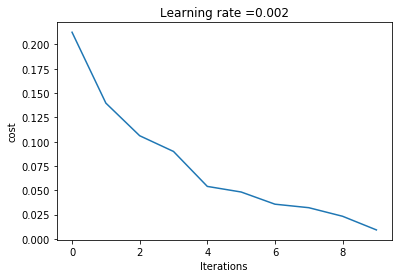

In [0]:
final_param,sess,pred_train,pred_test = model(X_train,Y_train,X_test,Y_test,parameters, learning_rate = 0.002,epochs = 55, minibatch_size = 600)

In [0]:
Fashion_label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}
Number_label_dict = {
 0: 'Zero',
 1: 'One',
 2: 'Two',
 3: 'Three',
 4: 'Four',
 5: 'Five',
 6: 'Six',
 7: 'Seven',
 8: 'Eight',
 9: 'Nine'
}

Actual = [9] (Ankle boot)
Prediction = 9 (Ankle boot)


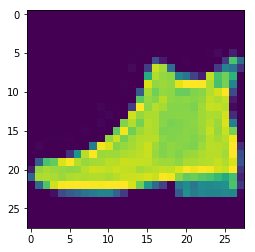

In [0]:
ind = 123
plt.imshow(X_test_orig[ind])
i=Y_test_orig[ind]
j = sess.run(pred_test[ind])
print("Actual = " + str(i) + " (" + str(Fashion_label_dict[i[0]]) + ")")
print("Prediction = "+str(j)+" ("+str(Fashion_label_dict[j])+")")

In [0]:
Y_test_pred = np.array(sess.run(pred_test))
mis_lab = []
for i in range(9999):
    if Y_test_pred[i] !=  Y_test_orig[i]:
        mis_lab.append(i)
print('Total wrong predictions = '+ str(len(mis_lab)))  

Total wrong predictions = 816


Actual = [3] (Dress)
Prediction = 6 (Shirt)


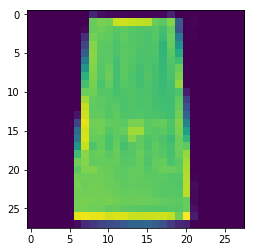

In [0]:
ind = mis_lab[3]
plt.imshow(X_test_orig[ind])
i=Y_test_orig[ind]
i = i.astype(int)
j = sess.run(pred_test[ind])
print("Actual = " + str(i) + " (" + str(Fashion_label_dict[i[0]]) + ")")
print("Prediction = "+str(j)+" ("+str(Fashion_label_dict[j])+")")

In [0]:
tf.trainable_variables()

[<tf.Variable 'W1:0' shape=(3, 3, 1, 20) dtype=float32_ref>,
 <tf.Variable 'W2:0' shape=(3, 3, 20, 50) dtype=float32_ref>,
 <tf.Variable 'fully_connected/weights:0' shape=(3920, 1200) dtype=float32_ref>,
 <tf.Variable 'fully_connected/biases:0' shape=(1200,) dtype=float32_ref>,
 <tf.Variable 'fully_connected_1/weights:0' shape=(1200, 10) dtype=float32_ref>,
 <tf.Variable 'fully_connected_1/biases:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'fully_connected_2/weights:0' shape=(3920, 1200) dtype=float32_ref>,
 <tf.Variable 'fully_connected_2/biases:0' shape=(1200,) dtype=float32_ref>,
 <tf.Variable 'fully_connected_3/weights:0' shape=(1200, 10) dtype=float32_ref>,
 <tf.Variable 'fully_connected_3/biases:0' shape=(10,) dtype=float32_ref>]